In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import optimize
from scipy import stats
import pandas as pd

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [2]:
def f(w):
    x = w[0]
    y = w[1]
    return (4 - 2.1*(x**2) + (x**4)/3)*(x**2) + x*y + (4*(y**2)-4)*(y**2)

In [3]:
# find global minima
opt1 = optimize.minimize(f, x0=(0,-1), method='Nelder-Mead')
opt2 = optimize.minimize(f, x0=(0,1), method='Nelder-Mead')
print("Global minima has a function value of %2.6f" % (opt1.fun))
print("Corresponding to the coordinates ", np.round(opt1.x, 6), " and ", np.round(opt2.x, 6))
print("\nThere are two global minima with the same function value because of the symmetry of the function.\n"
      "In fact, the point of coordinates [x y] and [-x -y] have the same function value.")

Global minima has a function value of -1.031628
Corresponding to the coordinates  [ 0.089848 -0.712676]  and  [-0.089849  0.712676]

There are two global minima with the same function value because of the symmetry of the function.
In fact, the point of coordinates [x y] and [-x -y] have the same function value.


In [4]:
# study the (0,0) case
opt3 = optimize.minimize(f, x0=(0,0))
opt4 = optimize.minimize(f, x0=(0,0), method="Nelder-Mead")
print("With the default solver, the minimum with initial guess [x y]=[0 0] is in ", opt3.x)
print("While with another solver (the Nelder-Mead algorithm for instance), the minimum with initial guess [0 0]\n"
      "is in ", opt4.x)


With the default solver, the minimum with initial guess [x y]=[0 0] is in  [0. 0.]
While with another solver (the Nelder-Mead algorithm for instance), the minimum with initial guess [0 0]
is in  [-0.08985145  0.71266538]


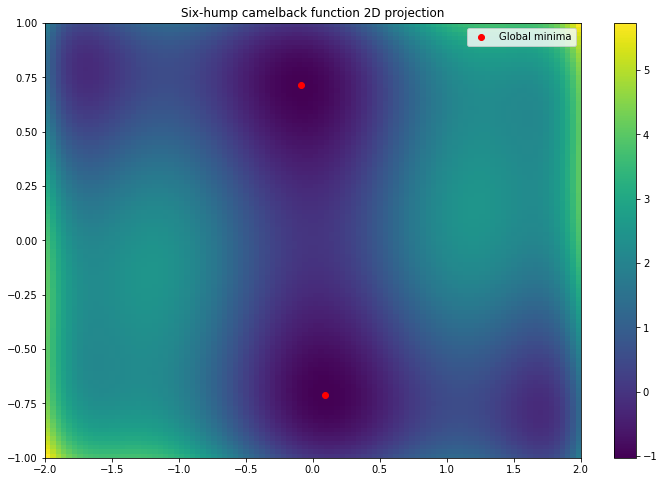

In [5]:
# prepare grid of values
xlim = (-2, 2)
ylim = (-1, 1)
x = np.linspace(xlim[0], xlim[1], 100)
y = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(x, y, sparse=True)
z = f([xx,yy])

# plot function
fig, ax = plt.subplots(1,1, figsize=(12,8))
axim = ax.imshow(z, extent=(xlim[0],xlim[1],ylim[0],ylim[1]), origin='lower', aspect='auto')
ax.set_title("Six-hump camelback function 2D projection")
fig.colorbar(mappable=axim)

# show minima
ax.scatter(x=[opt1.x[0],opt2.x[0]], y=[opt1.x[1],opt2.x[1]],
           c='r', label='Global minima')

ax.legend()
plt.show()


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

,tmax,tmin
Jan,17,-62
Feb,19,-59
Mar,21,-56
Apr,28,-46
May,33,-32
Jun,38,-18
Jul,37,-9
Aug,37,-13
Sep,31,-25
Oct,23,-46


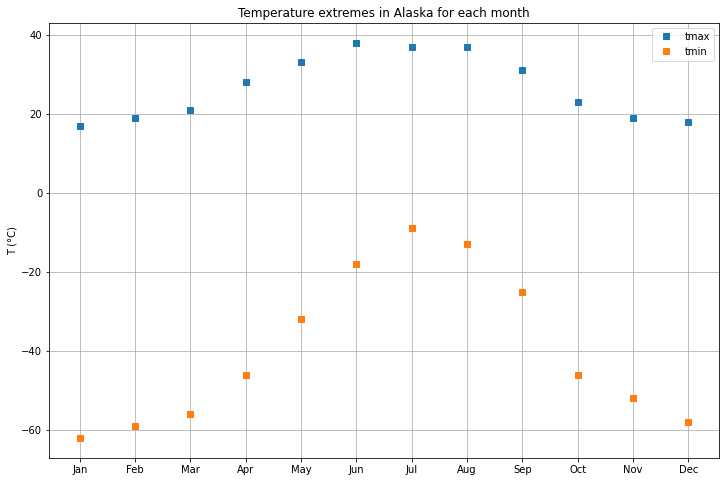

In [6]:
# prepare data
tmax = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
tmin = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
data = pd.DataFrame()
months = pd.date_range('2021', freq='M', periods=12).month_name().str[:3].values
data['tmax'] = tmax
data['tmin'] = tmin

fancy_data = data.set_index(data.index.map(lambda m: months[m]))
display(fancy_data)

# plot temperatures
fig, ax = plt.subplots(1,1, figsize=(12,8))
data.plot(y='tmax', ax=ax, marker='s', linestyle='none')
data.plot(y='tmin', ax=ax, marker='s', linestyle='none')

ax.set_xticks(range(12))
ax.set_xticklabels(months)
ax.set_title("Temperature extremes in Alaska for each month")
ax.set_ylabel("T (°C)")
ax.grid()

Gaussian function used for fitting:$$\text{gauss}\,(x,A,C,\mu,\sigma) = A+C\,\exp{\left[ -\frac{\left(x-\mu \right)^2}{2\,\sigma^2}  \right]}$$

In [7]:
def gauss(x, A, C, mu, sigma):
    return A + C*np.exp(-0.5*np.power((x-mu)/sigma, 2.))

Fit results of gauss(x)= A + C*np.exp(-0.5*np.power((x-mu)/sigma, 2.)) :

- Max temperatures:
	A (offset) 			= 15.77931 ± 1.17653
	C (scale) 			= 23.09209 ± 1.15265
	mu (1st moment) 		= 5.73582 ± 0.07947
	sigma (sqrt of 2nd moment) 	= 2.29444 ± 0.16596

- Min temperatures:
	A (offset) 			= -61.32094 ± 1.18882
	C (scale) 			= 52.64929 ± 1.40334
	mu (1st moment) 		= 6.16453 ± 0.04721
	sigma (sqrt of 2nd moment) 	= 1.97590 ± 0.07598


Convention used here: {0 : 'Jan'}, ..., {5 : 'Jun'}, {6 : 'Jul'}, ..., {11 : 'Dec'}



Graphically we can see that the two fits (seem to) decribe accurately the data.
But the 1st moments of the two gaussians are 4.64 standard deviations far.
So, within the fit accuracy it is not possible to find a suitable month that can be considered the 'hottest'
(i.e., the time offsets for min and max temperatures are not within the fit accuracy).


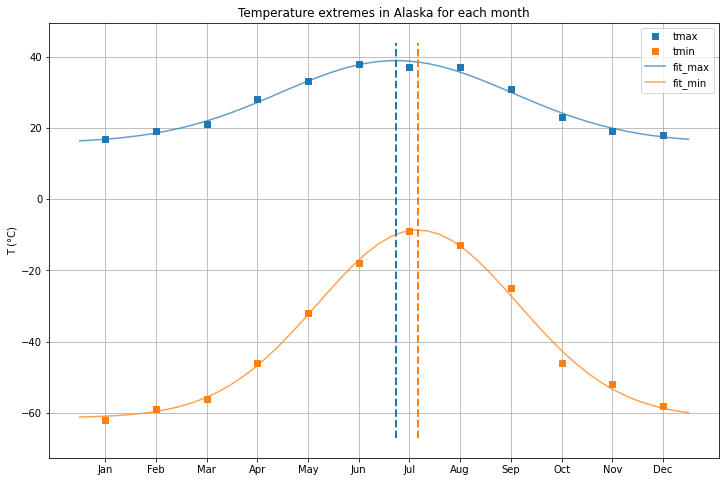

In [8]:
# fit data
opt_max, cov_max = optimize.curve_fit(f=gauss, xdata=data.index.values, ydata=data['tmax'].values, p0=[0,10,6,1])
opt_min, cov_min = optimize.curve_fit(f=gauss, xdata=data.index.values, ydata=data['tmin'].values, p0=[-70,10,6,1])
sqrt_max = np.sqrt(np.diag(cov_max))
sqrt_min = np.sqrt(np.diag(cov_min))

# plot fitted curves
x0 = np.linspace(-0.5,11.5,50)
ax.plot(x0, gauss(x0, opt_max[0], opt_max[1], opt_max[2], opt_max[3]), c='C0', alpha=0.7, label='fit_max')
ax.plot(x0, gauss(x0, opt_min[0], opt_min[1], opt_min[2], opt_min[3]), c='C1', alpha=0.7, label='fit_min')
ax.legend()


# print fit results
print("Fit results of gauss(x)= A + C*np.exp(-0.5*np.power((x-mu)/sigma, 2.)) :\n")
print("- Max temperatures:")
print("\tA (offset) \t\t\t= %2.5f ± %2.5f" % (opt_max[0], sqrt_max[0]))
print("\tC (scale) \t\t\t= %2.5f ± %2.5f" % (opt_max[1], sqrt_max[1]))
print("\tmu (1st moment) \t\t= %2.5f ± %2.5f" % (opt_max[2], sqrt_max[2]))
print("\tsigma (sqrt of 2nd moment) \t= %2.5f ± %2.5f" % (opt_max[3], sqrt_max[3]))

print("\n- Min temperatures:")
print("\tA (offset) \t\t\t= %2.5f ± %2.5f" % (opt_min[0], sqrt_min[0]))
print("\tC (scale) \t\t\t= %2.5f ± %2.5f" % (opt_min[1], sqrt_min[1]))
print("\tmu (1st moment) \t\t= %2.5f ± %2.5f" % (opt_min[2], sqrt_min[2]))
print("\tsigma (sqrt of 2nd moment) \t= %2.5f ± %2.5f" % (opt_min[3], sqrt_min[3]))

print("\n\nConvention used here: {0 : 'Jan'}, ..., {5 : 'Jun'}, {6 : 'Jul'}, ..., {11 : 'Dec'}\n")


# plot vertical lines for comparison
ax.vlines(x=[opt_max[2],opt_min[2]], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],
          colors=['C0','C1'], linestyles='dashed', linewidths=2)


# explain the differences
print("\n\nGraphically we can see that the two fits (seem to) decribe accurately the data.\n"
      "But the 1st moments of the two gaussians are %2.2f standard deviations far.\n"
      "So, within the fit accuracy it is not possible to find a suitable month that can be considered the 'hottest'\n"
      "(i.e., the time offsets for min and max temperatures are not within the fit accuracy)."
      % (np.abs(opt_max[2]-opt_min[2])/np.sqrt(sqrt_max[2]**2 + sqrt_min[2]**2)))

fig

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


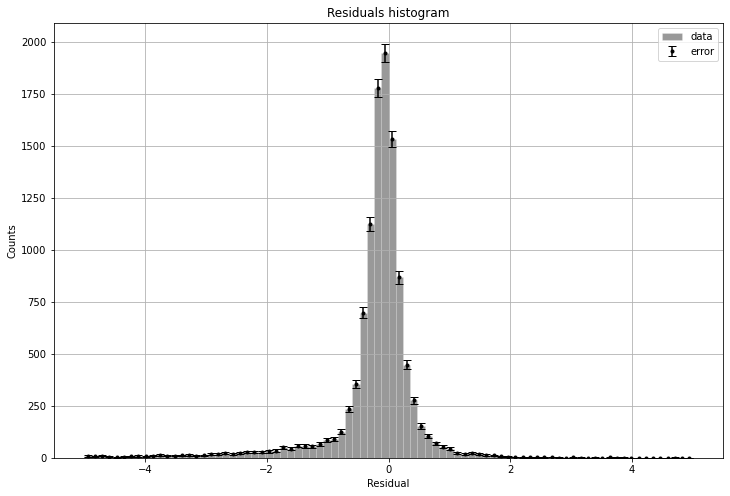

In [9]:
# import data
data = pd.DataFrame(pd.read_pickle("residuals_261.pkl").flatten()[0])
data_res = data['residuals']
display(data)

# display histogram
fig, ax = plt.subplots(1,1,figsize=(12,8))
hn, hbin, _ = ax.hist(data_res, bins=int(0.8*np.sqrt(len(data))), linewidth=0.5, range=(-5,5),
                     label='data', edgecolor='white', alpha=0.4, color='k')
ax.grid()
ax.set_title("Residuals histogram")
ax.set_ylabel("Counts")
ax.set_xlabel("Residual")

# display error bar
xbin = (hbin[1:]+hbin[:-1])*0.5
ax.errorbar(x=xbin, y=hn, yerr=np.sqrt(hn),
            fmt='.', capsize=4, color='k', label='error')

ax.legend()
plt.show()

In [10]:
def cauchy (x, A, B, mu):
    return A/(B**2 + np.power(x-mu, 2.))

R^2 for gaussian fit 	= 1 - 1.17019e-05
R^2 for cauchy fit 	= 1 - 6.91013e-06

chi^2 for gaussian fit 	= 5052.60347
chi^2 for cauchy fit 	= 1334.91092

p-value of the gaussian fit 	= 0.00000e+00
p-value of the cauchy fit 	= 4.07052e-226


/var/folders/91/bv1myz2n5wxg_x3zg5p_5mnc0000gn/T/ipykernel_1036/963525189.py:23: RuntimeWarning: divide by zero encountered in true_divide
  frac_g = (gauss(xbin,opt_g[0],opt_g[1],opt_g[2],opt_g[3])-hn)/np.sqrt(hn)
/var/folders/91/bv1myz2n5wxg_x3zg5p_5mnc0000gn/T/ipykernel_1036/963525189.py:24: RuntimeWarning: divide by zero encountered in true_divide
  frac_c = (cauchy(xbin,opt_c[0],opt_c[1],opt_c[2])-hn)/np.sqrt(hn)


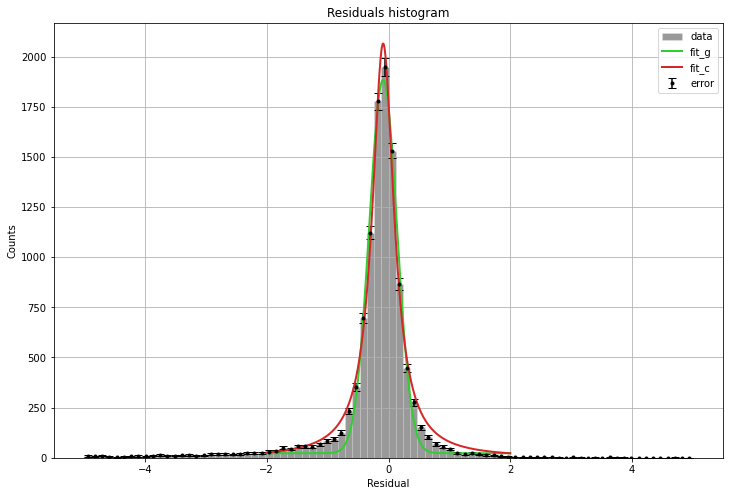

In [11]:
# fit data
opt_g, cov_g = optimize.curve_fit(f=gauss, xdata=(hbin[1:]+hbin[:-1])*0.5, ydata=hn, p0=[0,1500,0,1])
opt_c, cov_c = optimize.curve_fit(f=cauchy, xdata=(hbin[1:]+hbin[:-1])*0.5, ydata=hn, p0=[1,1,0])

# plot fitted curves
x0 = np.linspace(-2,2,500)
ax.plot(x0, gauss(x0, opt_g[0], opt_g[1], opt_g[2], opt_g[3]), c='limegreen', lw=2, label='fit_g')
ax.plot(x0, cauchy(x0, opt_c[0], opt_c[1], opt_c[2]), c='C3', lw=2, label='fit_c')
ax.legend()

# perform a goodness-of-fit test
# R^2
R2_g = 1 - np.sum(np.power(gauss(xbin,opt_g[0],opt_g[1],opt_g[2],opt_g[3])-hn, 2.))/np.sum(np.power(np.sum(hn)-hn, 2.))
R2_c = 1 - np.sum(np.power(cauchy(xbin,opt_c[0],opt_c[1],opt_c[2])-hn, 2.))/np.sum(np.power(np.sum(hn)-hn, 2.))
print("R^2 for gaussian fit \t= 1 - %2.5e" % (1-R2_g))
print("R^2 for cauchy fit \t= 1 - %2.5e" % (1-R2_c))

# Chi^2
# (keep in consideration that some bins are zero, so they add an infinite factor
# in the computation of the chi^2)
ndof_g = len(xbin)-4
ndof_c = len(xbin)-3
frac_g = (gauss(xbin,opt_g[0],opt_g[1],opt_g[2],opt_g[3])-hn)/np.sqrt(hn)
frac_c = (cauchy(xbin,opt_c[0],opt_c[1],opt_c[2])-hn)/np.sqrt(hn)
chi2_c = np.sum(np.power(frac_c[np.isfinite(frac_c)], 2.))
chi2_g = np.sum(np.power(frac_g[np.isfinite(frac_g)], 2.))
print("\nchi^2 for gaussian fit \t= %2.5f" % (chi2_g))
print("chi^2 for cauchy fit \t= %2.5f" % (chi2_c))

# compute P-value using the survival funcion (sf = 1 - cdf)
pval_g = stats.chi2.sf(chi2_g,ndof_g)
pval_c = stats.chi2.sf(chi2_c,ndof_c)
print("\np-value of the gaussian fit \t= %2.5e" % (pval_g))
print("p-value of the cauchy fit \t= %2.5e" % (pval_c))


fig

**Even though the $R^2$ estimates are approximately 1 for both the fits (that means a perfect fit), the computed P-values of the $\chi^2$ demonstrate that the fits are not acceptable at all. This divergence of opinions is caused by the fact that the $R^2$ does not take into account the uncertainties of the data.**

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [12]:
# import data and define functions to be fitted
data = pd.read_csv("munich_temperatures_average_with_bad_data.txt", sep=' ', names=['time','temp'])
display(data)

def f(t, a, b, c):
    return a * np.cos(2*np.pi*t + b) + c

def g(t, a, b, c, d):
    return a * np.cos(2*np.pi*b*t + c) + d

,time,temp
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


Fit results of f(x)= a * np.cos(2*np.pi*t + b) + c :
	a (amplitude) 		= 9.96203 ± 0.13250
	b (time-shift) 		= 2.90696 ± 0.01332
	c (temperature-shift) 	= 9.26282 ± 0.09375

Average temperature in Munich (computed over all the dataset)
	T_mean = 8.94 °C

Typical daily temperature average in the coldest time of the year (predicted by the model)
	T_cold = -0.70

Typical daily temperature average in the hottest time of the year (predicted by the model)
	T_hot = 19.22

The b-parameter is the time shift added to the fit function because the maximum of temperature does not
occur at integers value of t (in other words, the 1st January is not the hottest day of the year) as the
cosine function would require.
The value of b put in this form has not a direct physical meaning, but the value of 1-(b/2π) represents
the time of the year in which the temperature is higher. So, in this model the hottest day of the year
is after 196 days.


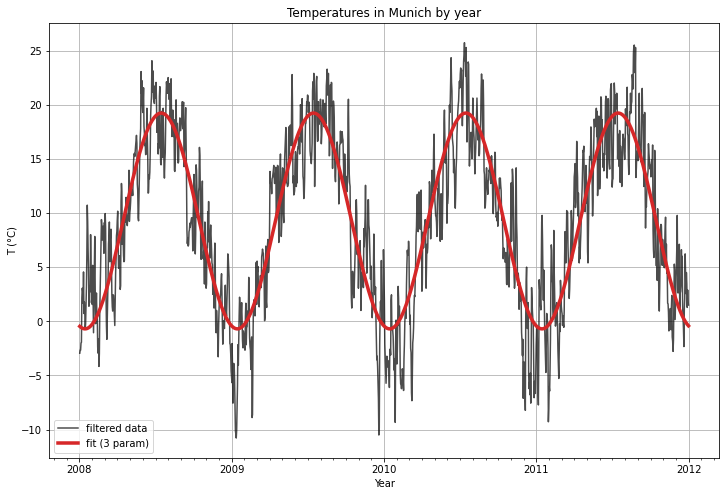

In [13]:
# consider only the temperatures of four years (2008-2012)
# and filter out the 'bad data'
trange = (2008<=data['time']) & (data['time']<=2012) & (np.abs(data['temp'])<50)
xdata, ydata = data.loc[trange,'time'], data.loc[trange,'temp']

# perform a bounded fit
opt1, cov1 = optimize.curve_fit(f=f, xdata=xdata, ydata=ydata, p0=[10,0,0],
                                bounds=([0,-np.pi,ydata.min()], [np.inf,np.pi,ydata.max()]))
sqrt1 = np.sqrt(np.diag(cov1))

# plot data
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(xdata, ydata, label='filtered data', alpha=0.7, color='k')
ax.grid()
ax.set_title("Temperatures in Munich by year")
ax.set_ylabel("T (°C)")
ax.set_xlabel("Year")
ax.set_xticks(np.round(ax.get_xticks()[ax.get_xticks()%1==0]))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(12))

# plot first fit
x0 = np.linspace(xdata.head(1).values,xdata.tail(1).values,1000)
ax.plot(x0, f(x0, opt1[0], opt1[1], opt1[2]), c='C3', alpha=1, label='fit (3 param)', lw=3.5)

print("Fit results of f(x)= a * np.cos(2*np.pi*t + b) + c :")
print("\ta (amplitude) \t\t= %2.5f ± %2.5f" % (opt1[0], sqrt1[0]))
print("\tb (time-shift) \t\t= %2.5f ± %2.5f" % (opt1[1], sqrt1[1]))
print("\tc (temperature-shift) \t= %2.5f ± %2.5f" % (opt1[2], sqrt1[2]))

print("\nAverage temperature in Munich (computed over all the dataset)\n\tT_mean = %2.2f °C"
      % data['temp'].mean())
print("\nTypical daily temperature average in the coldest time of the year (predicted by the model)\n"
      "\tT_cold = %2.2f" % (-opt1[0]+opt1[2]))
print("\nTypical daily temperature average in the hottest time of the year (predicted by the model)\n"
      "\tT_hot = %2.2f" % (opt1[0]+opt1[2]))
print("\nThe b-parameter is the time shift added to the fit function because the maximum of temperature does not\n"
      "occur at integers value of t (in other words, the 1st January is not the hottest day of the year) as the\n"
      "cosine function would require.\n"
      "The value of b put in this form has not a direct physical meaning, but the value of 1-(b/2π) represents\n"
      "the time of the year in which the temperature is higher. So, in this model the hottest day of the year\n"
      "is after %i days." % ( (1-(opt1[1]/(2*np.pi)))*365.25 ))

ax.legend()
plt.show()

Fit results of g(x)= a * np.cos(2*np.pi*b*t + c) + d :
	a (amplitude) 		= 9.96078 ± 0.13327
	b (periods in a year) 	= 1.00029 ± 0.00188
	c (time-shift) 		= -0.78340 ± 23.79113
	d (temperature-shift) 	= 9.26566 ± 0.09555


SSR of f(x) (with 3 parameters) = 18669.515
SSR of g(x) (with 4 parameters) = 18669.225

F-Test:
	F = 	0.02261
	CL = 	0.88049
The additional parameter used in g(x) does not improve the fit performances.



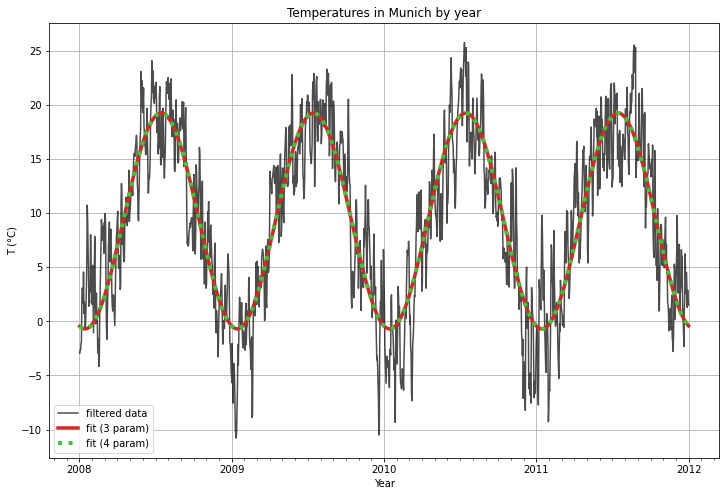

In [14]:
# perform a bounded fit
opt2, cov2 = optimize.curve_fit(f=g, xdata=xdata, ydata=ydata, p0=[10,1,0.1,0],
                                bounds=([5,0.1,-np.pi,ydata.min()], [15,10,np.pi,ydata.max()]))
sqrt2 = np.sqrt(np.diag(cov2))

# plot second fit
ax.plot(x0, g(x0, opt2[0], opt2[1], opt2[2], opt2[3]), c='limegreen', alpha=1, label='fit (4 param)',
        lw=4, ls=':')

print("Fit results of g(x)= a * np.cos(2*np.pi*b*t + c) + d :")
print("\ta (amplitude) \t\t= %2.5f ± %2.5f" % (opt2[0], sqrt2[0]))
print("\tb (periods in a year) \t= %2.5f ± %2.5f" % (opt2[1], sqrt2[1]))
print("\tc (time-shift) \t\t= %2.5f ± %2.5f" % (opt2[2], sqrt2[2]))
print("\td (temperature-shift) \t= %2.5f ± %2.5f" % (opt2[3], sqrt2[3]))

# compute and show SSR
SSR1 = np.sum(np.power(f(xdata,opt1[0],opt1[1],opt1[2])-ydata, 2.))
SSR2 = np.sum(np.power(g(xdata,opt2[0],opt2[1],opt2[2],opt2[3])-ydata, 2.))
ndof1 = 3 - 1
ndof2 = 4 - 1
print("\n\nSSR of f(x) (with 3 parameters) = %2.3f" % (SSR1))
print("SSR of g(x) (with 4 parameters) = %2.3f" % (SSR2))

# F-Test
F = ((SSR1-SSR2)/(ndof2-ndof1))/(SSR2/(len(xdata)-ndof2))
CL = stats.f.sf(F, ndof2 - ndof1, len(xdata) - ndof2)
print("\nF-Test:\n\tF = \t%2.5f" % (F))
print("\tCL = \t%2.5f" % (CL))
print("The additional parameter used in g(x) does not improve the fit performances.\n")

ax.legend()
fig